In [1]:
import json
import functools
import collections
from glob import glob
import os
import itertools
from importlib import reload

os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import persim
import utils
from sklearn import decomposition, preprocessing

In [3]:
normtype = 'gene'
level = 'sub'
n_components = 2
fs = 12
dpi = 96
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']

seed = 42
SCALE = 16
ndims = 3
perms = [np.nonzero(p)[0] for p in itertools.product(range(2), repeat=ndims)][1:]

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
dst = '..' + os.sep + 'infected_focus_summer24' + os.sep 
sample = 'D2'

dst += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col=0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep

Cells = utils.get_range_cell_values(dst + 'infected_cells_ids.csv', metacell, startval=1)
Cells = np.setdiff1d( Cells, metacell[metacell['number_nuclei'] > 1].index)
Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
#Genes = Genes[[0,-1]]

transfocus = transcell.loc[Genes, Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')

print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by gene:	5.99%


,169,188,199,209,224,227,233,235,236,243,...,2511,2514,2515,2523,2529,2536,2548,2552,2573,2576
85,966,2402,727,307,1012,901,828,1263,1314,315,...,810,1268,181,210,1106,363,679,760,574,772
28,27,29,20,2,12,21,8,19,23,0,...,9,8,2,3,19,4,10,7,8,22
84,22,48,10,12,5,5,24,21,27,15,...,16,10,1,3,3,13,10,13,7,2
27,3,21,0,0,0,0,0,3,2,1,...,1,0,1,0,13,0,1,0,0,0
74,11,35,14,14,10,5,28,24,20,7,...,15,18,3,5,16,8,16,6,12,6
26,462,1685,638,502,462,481,629,978,694,320,...,655,818,196,407,1067,417,428,714,344,478


In [4]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
PP = 6
stepsize = 3
bw = 20

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[926 908 914 444 918 926]


In [5]:
minlife = 0.0
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
lt_mask = np.any(maxlife > minlife, axis=2)
gmask, cmask = np.nonzero(lt_mask)
bsummary = pd.DataFrame()
bsummary['gene_ID'] = Genes[gmask]
bsummary['ndimage_ID'] = Cells[cmask]

uq , cts = np.unique(gmask, return_counts=True)
nzcumsum = np.hstack(([0], np.cumsum(cts) ))

Initial number of life-birth pairs	: 166394

No. of diagrams s.t. H_k had the most persistent component
H_0:	747 [ 13.4% ]
H_1:	3 [ 0.1% ]
H_2:	4806 [ 86.5% ]

Will focus just on dimension k = 2



In [6]:
if normtype == 'gene':
    diags = [ [ [ rescale[i][0][0]*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
elif normtype == 'both':
    diags = [ [ [ rescale*orig_diags[i][j][k].copy() for k in range(len(orig_diags[i][j])) ] for j in range(len(orig_diags[i])) ] for i in range(len(orig_diags)) ]
for i in range(len(diags)):
    for j in range(len(diags[i])):
        for k in range(len(diags[i][j])):
            diags[i][j][k] = np.atleast_2d(diags[i][j][k][ diags[i][j][k][:,1] - diags[i][j][k][:,0] > minlife, : ])

lt_coll = [ [None for _ in range(np.sum(lt_mask)) ] for _ in range(ndims) ]
for i in range(len(gmask)):
    for k in range(len(lt_coll)):
        d = diags[gmask[i]][cmask[i]][k]
        lt_coll[k][i] = np.column_stack( (d[:, 0], d[:, 1] - d[:, 0])  )

maxbirth = 0
for k in range(len(lt_coll)):
    for i in range(len(lt_coll[k])):
        if len(lt_coll[k][i]) > 0:
            b = np.max(lt_coll[k][i][:,0])
            if b > maxbirth:
                maxbirth = b

maxbirth

13.560126869249865

# Persistence Images

In [7]:
sigma = 1
persw = 1
pixsz = 1
alpha = 0.25
iqr_factor = 1.5

pi_params = {'birth_range':(0,min([SCALE, int(np.ceil(maxbirth + sigma))] )),
             'pers_range':(0,min([SCALE, int(np.ceil(maxlife[:,:,focus_dim].max()+sigma))])),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': persw},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }
                           
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ]).astype(int)
print(extent)
bname = 'scale{}_-_PI_{}_{}_{}_'.format(SCALE, sigma, persw, pixsz)
foo = [bw, stepsize, level.title(), normtype.title(), sigma, persw]
Bname = 'KDE bandwidth {}, stepsize {}. {}level persistence. {} normalized. PIs $\sigma = {}$. Weighted by $n^{{{}}}$.'.format(*foo)
tdst = dst + 'G{}_{}level_{}_step{}_bw{}'.format(len(Genes), level, normtype, stepsize, bw) + os.sep
if not os.path.isdir(tdst):
    os.mkdir(tdst)
    print(tdst)

[ 0 15  0 12]


In [8]:
img = np.zeros((len(lt_coll), len(lt_coll[0]), extent[1], extent[3]))
for k in range(len(img)):
    img[k] = np.asarray(pimgr.transform(lt_coll[k], skew=False))
img[img < 0] = 0

pi = np.zeros((img.shape[0], img.shape[1], img.shape[2]*img.shape[3]))
for k in range(len(pi)):
    pi[k] = img[k].reshape(pi.shape[1], pi.shape[2])

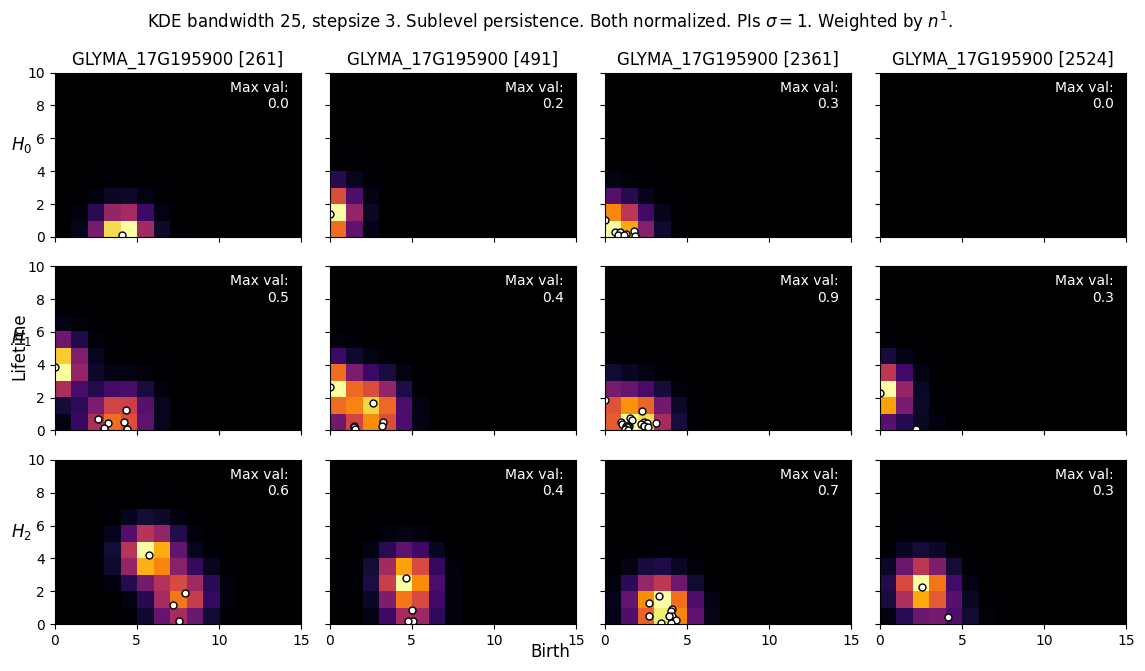

In [12]:
idx = [11,   90,  890, 919]

fig, ax = plt.subplots(len(img),len(idx), figsize=(3*len(idx), 7), sharex=True, sharey=True)
#ax = np.atleast_1d(ax).ravel(); i = 0

for k in range(len(img)):
    for i in range(len(idx)):
        ax[k,i].imshow(img[k, idx[i]].T, cmap='inferno', vmin=0, origin='lower', extent=extent)
        ax[k,i].text((extent[1] - extent[0])*.95, (extent[3] - extent[2])*.95, 
                    'Max val:\n{:.1f}'.format(np.max(img[k,idx[i]])), color='w', ha='right', va='top')
        ax[k,i].scatter(lt_coll[k][idx[i]][:,0], lt_coll[k][idx[i]][:,1], c='w', marker='o', s=25, edgecolor='k', linewidth=1)
    ax[k,0].set_ylabel('$H_{}$'.format(k), fontsize=fs, rotation=0)

for i in range(len(idx)):
    ax[0,i].set_title('{} [{}]'.format(transcriptomes[Genes[gmask[idx[i]]]], metacell.loc[Cells[cmask[idx[i]]], 'orig_cellID']), fontsize=fs)

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('Birth', fontsize=fs, y=0.05)
fig.supylabel('Lifetime', fontsize=fs, x=0.05)
fig.tight_layout();

In [13]:
avg = np.zeros( (len(img), len(nzcumsum) - 1, pimgr.resolution[1], pimgr.resolution[0]))
for k in range(len(avg)):
    for i in range(avg.shape[1]):
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        avg[k,i] = np.mean(img[k,s_], axis=0).T

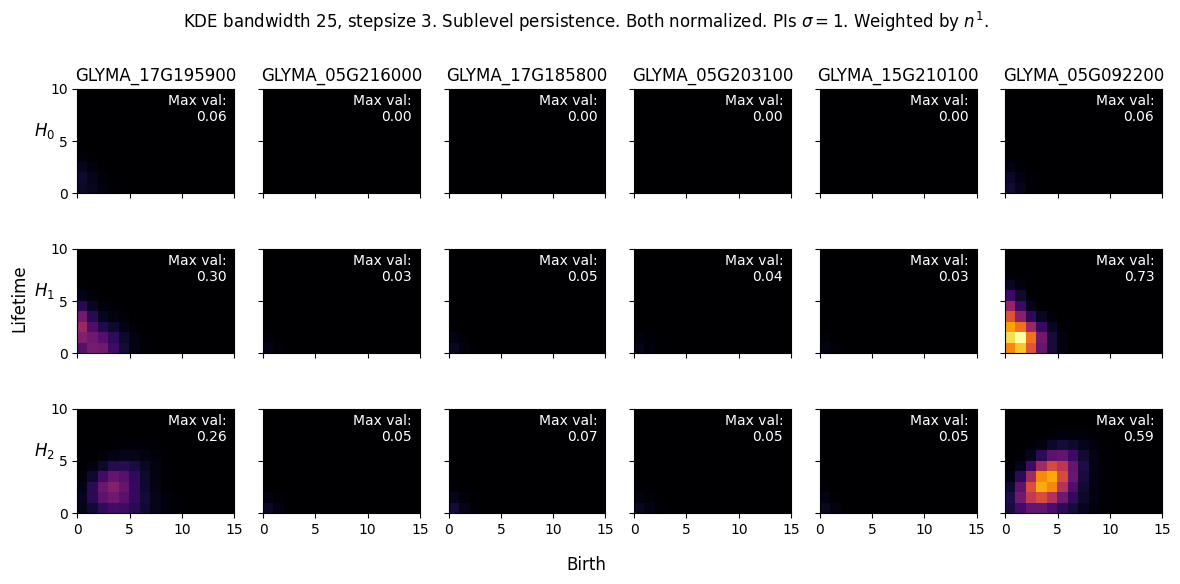

In [14]:
vmax = avg.max()
fig, ax = plt.subplots(len(avg), avg.shape[1], figsize=(2*avg.shape[1], 6), sharex=True, sharey=True)

for k in range(avg.shape[0]):
    for i in range(len(nzcumsum)-1):
        ax[k,i].imshow(avg[k,i], cmap='inferno', origin='lower', vmin=0, vmax=vmax, extent=extent)
        ax[k,i].text((extent[1] - extent[0])*.95, (extent[3] - extent[2])*.95, 
                     'Max val:\n{:.2f}'.format(np.max(avg[k,i])), color='w', ha='right', va='top')
    ax[k,0].set_ylabel('$H_{}$'.format(k), fontsize=fs, rotation=0)
for i in range(avg.shape[1]):
    ax[0,i].set_title(transcriptomes[Genes[i]], fontsize=fs)

fig.supxlabel('Birth', y=.04, fontsize=fs); 
fig.supylabel('Lifetime', fontsize=fs)
fig.suptitle(Bname, fontsize=fs)

fig.tight_layout()
#filename = tdst + bname + 'average_PI'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [9]:
maxpis = np.max(pi, axis=2)
boxes = [ [ maxpis[k, nzcumsum[i]:nzcumsum[i+1]] for i in range(len(nzcumsum)-1) ] for k in range(len(maxpis)) ]
qq = np.asarray([ [ np.quantile(boxes[k][i], [alpha, 1-alpha]) for i in range(len(boxes[k])) ] for k in range(len(boxes)) ])
thr = np.max(qq[:,:,1] + iqr_factor*(qq[:,:,1] - qq[:,:,0]), axis=1)

# Reduce dimension

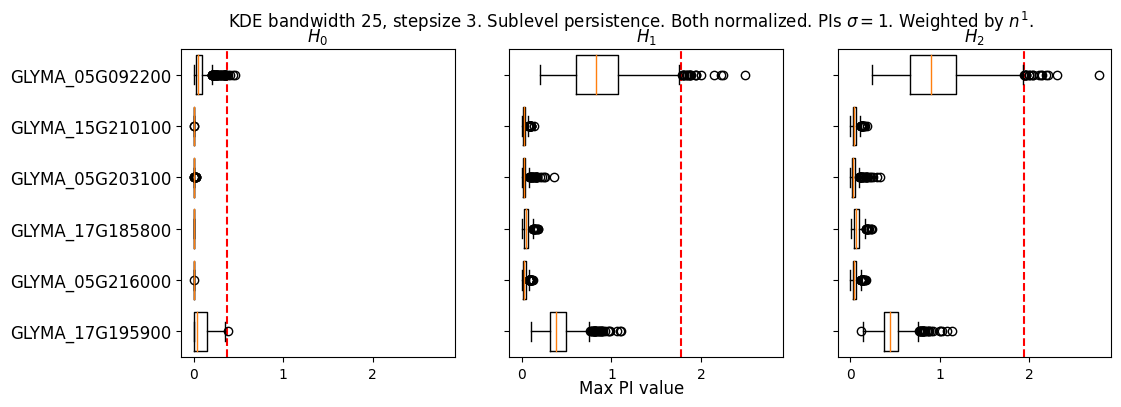

In [16]:
fig, ax = plt.subplots(1, len(thr), figsize=(12, 2*len(Genes)/3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); 
for k in range(len(ax)):
    ax[k].axvline(thr[k], c='r', ls='--', zorder=1)
    ax[k].boxplot(boxes[k], vert=False, zorder=2, widths=0.75)
    ax[k].set_title('$H_{}$'.format(k), fontsize=fs)

ax[0].set_yticks(range(1, len(Genes)+1), transcriptomes[Genes], fontsize=fs)

fig.suptitle(Bname, fontsize=fs)
fig.supxlabel('Max PI value', fontsize=fs)
filename = tdst + bname + 'max_PI_val_boxplot'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [10]:
def plot_embedding(embedding, alpha=0.05, title=None, nrows=2, ncols=4):
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nzcumsum) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', s=1, alpha=1, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=color[i], marker=marker[i], alpha=0.75, zorder=2,
                      edgecolor='k', linewidth=0.5)
        ax[i].set_title(transcriptomes[Genes[i]])
        ax[i].set_xlim(mn[0],mx[0]);ax[0].set_ylim(mn[1],mx[1])
        #ax[i].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if title is not None:
        fig.supxlabel(title + ' 01')
        fig.supylabel(title + ' 02')
    
    return fig, ax

In [11]:
perm = perms[2]
print(perm)
pname = 'H' + '+'.join(perm.astype(str))
Pname = ' [$' + ' \\oplus '.join(['H_{}'.format(k) for k in perm]) + '$]'
full_pi = np.hstack(pi[perm])
print(full_pi.shape)
maxmask = np.ones(len(full_pi), dtype=bool)
maxmask[functools.reduce(np.union1d, [np.nonzero(maxpis[k] > thr[k])[0] for k in perm])] = False
print(full_pi[maxmask].shape)

scaler = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True)
data = scaler.fit_transform(full_pi[maxmask].copy())
fulldata = scaler.transform(full_pi)
print(data.shape, fulldata.shape)

[1 2]
(4809, 360)
(4751, 360)
(4751, 360) (4809, 360)


# PCA

In [12]:
method = 'PCA'
PCA = decomposition.PCA(n_components=min([6, data.shape[1]//20]), random_state=seed)
print('Considering the first', PCA.n_components,'PCs')
PCA.fit(data)
pca = PCA.transform(fulldata).astype('float32')
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

Considering the first 6 PCs
[36.95555556 32.71829079  7.85911959  7.16920048  3.07943219  2.66951068]
Total explained var:	 90.45110929493262 69.6738463503199


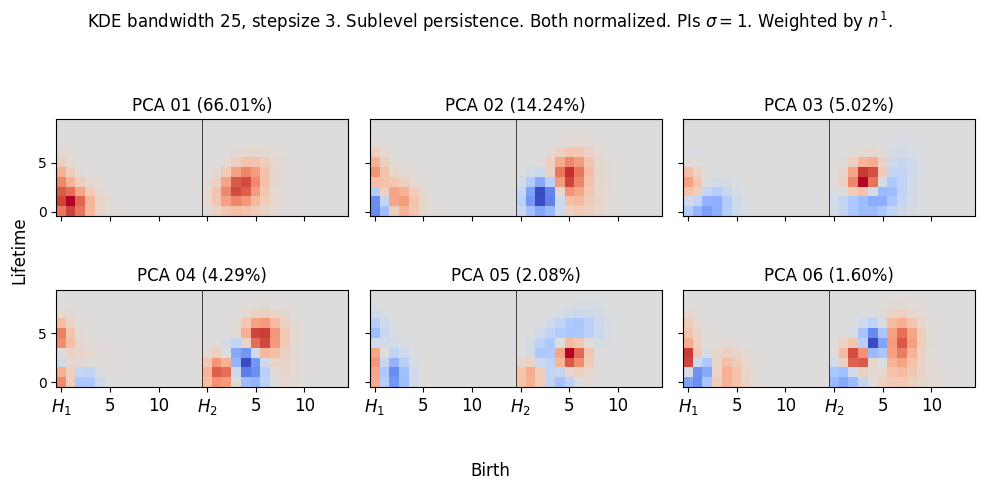

In [20]:
pcacol = 3
pcarow = np.where(pca.shape[1] % pcacol == 0, pca.shape[1]//pcacol, pca.shape[1]//pcacol + 1) + 0

xlabs = np.tile(np.arange(0, img.shape[2], img.shape[2]//3), len(perm))
xticks = np.hstack([ np.arange(0, img.shape[2], xlabs[1]-xlabs[0]) + i*img.shape[2] for i in range(len(perm)) ])
xlabs = xlabs.astype(str)
xlabs[xlabs == '0'] = [ '$H_{}$'.format(perm[i]) for i in range(len(perm)) ]

fig, ax = plt.subplots(pcarow, pcacol, figsize=(10, 2.5*pcarow), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(loadings.shape[1]):
    ll = loadings[:,i].reshape( len(perm)*img.shape[2], img.shape[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower')
    ax[i].set_title('{} {:02d} ({:.2f}%)'.format(method, i+1, explained_ratio[i]), fontsize=fs)
    for j in range(1, len(perm)):
        ax[i].axvline(j*img.shape[2] - .5, c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs, fontsize=fs)

for i in range(loadings.shape[1], len(ax)):
    fig.delaxes(ax[i])
fig.supxlabel('Birth', y=.04, fontsize=fs); 
fig.supylabel('Lifetime', fontsize=fs)
fig.suptitle(Bname, fontsize=fs)
fig.tight_layout();
filename = tdst + bname + method.lower() + '_' + pname +'_loadings'
#plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

In [21]:
summary = bsummary.join(pd.DataFrame(pca, columns=['{}{:02d} ({:.2f})'.format(method,i+1,explained_ratio[i]) for i in range(pca.shape[1])]))
#summary.to_csv(tdst + bname + method.lower() + '_' + pname + '.csv', index=False)
summary

,gene_ID,ndimage_ID,PCA01 (66.01),PCA02 (14.24),PCA03 (5.02),PCA04 (4.29),PCA05 (2.08),PCA06 (1.60)
0,85,169,0.613139,0.032069,0.129036,-0.254390,-0.318870,0.231769
1,85,188,1.582704,0.833974,0.113548,0.327569,-0.394675,0.097703
2,85,199,0.196616,-0.522691,-0.298161,0.072949,-0.128879,-0.017877
3,85,209,0.070832,-0.118910,0.409958,-0.218982,0.074494,0.286678
4,85,224,0.312398,0.507286,0.370840,-0.151649,0.307368,0.067332
...,...,...,...,...,...,...,...,...
4779,26,2536,1.187910,-0.879649,0.224286,0.323930,0.362991,-0.032004
4780,26,2548,1.191270,-0.252902,-0.340353,1.030017,0.427336,0.234897
4781,26,2552,2.178630,1.676230,-0.184285,0.871362,-0.303391,-0.558719
4782,26,2573,2.441477,-2.279984,-0.473681,1.013818,0.475179,-0.344617


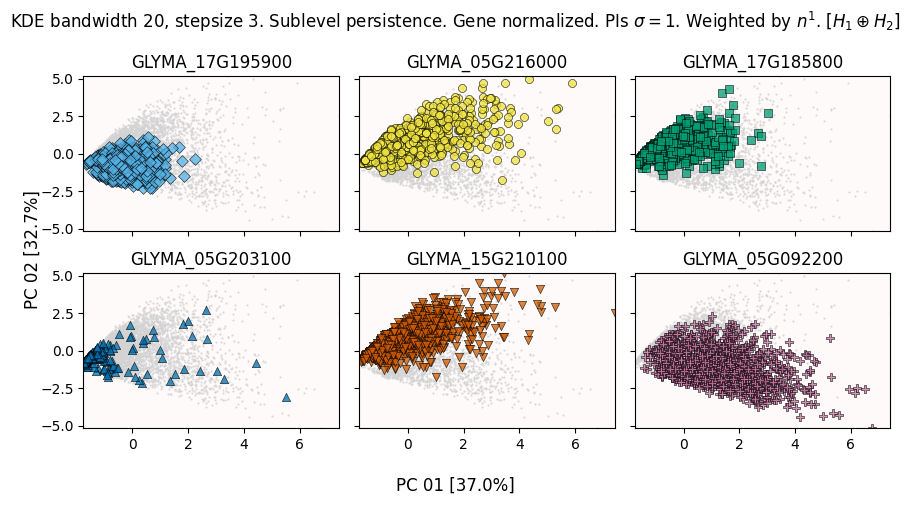

In [14]:
nrows, ncols = 2,3
fig, ax = plot_embedding(pca, 0.00, None, nrows=nrows, ncols=ncols)
fig.suptitle(Bname+Pname, fontsize=fs)
fig.supxlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
fig.supylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs)

fig.tight_layout();
filename = tdst + bname + method.lower() + '_' + pname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# KPCA

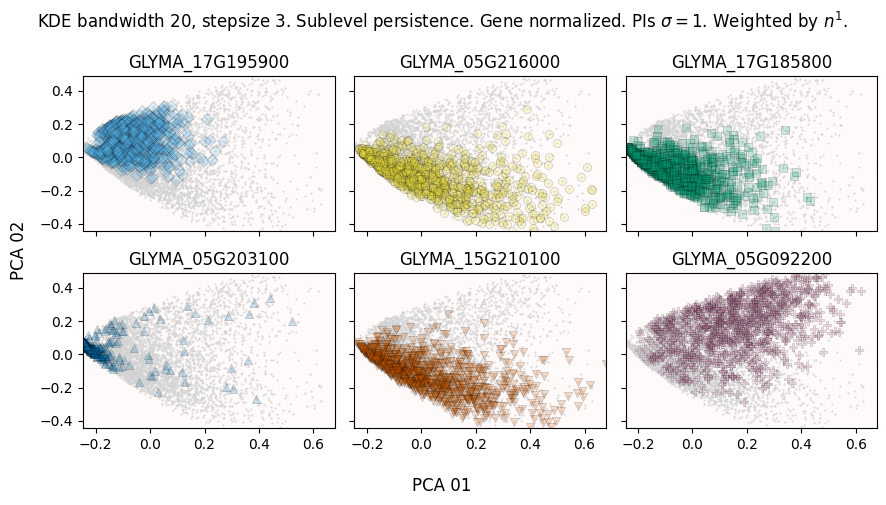

In [21]:
params = {'kernel':'rbf', 'gamma':0.01}
#params = {'kernel':'poly', 'gamma':0.001, 'degree':3}
#params = {'kernel':'sigmoid', 'gamma':0.1}

KPCA = decomposition.KernelPCA(n_components=2, **params)
KPCA.fit(data)
kpca = KPCA.transform(fulldata).astype('float32')

fig, ax = plot_embedding(kpca, 0.01, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();

# Locally Linear Embeddings

In [38]:
import umap
from sklearn import decomposition, preprocessing, manifold

In [45]:
method = 'LLE'
n_neighbors = 24  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2, "eigen_solver": "auto","random_state": seed}
LLE = manifold.LocallyLinearEmbedding(method="standard", **params)
LLE.fit(data)
lle = LLE.transform(fulldata).astype('float32')
params = LLE.get_params()

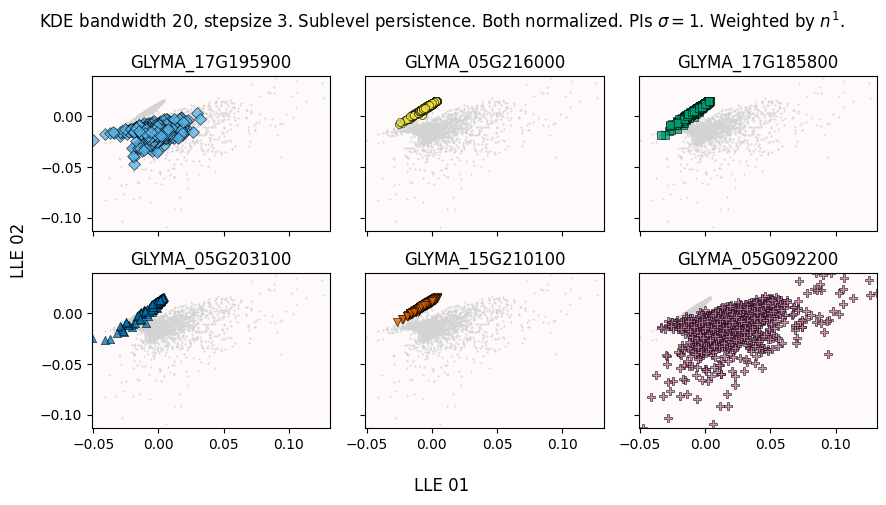

In [46]:
summary = pd.DataFrame(lle, columns=['{}{:02d}'.format(method, i+1) for i in range(lle.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(lle.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}_{}.csv'.format(method.lower(), LLE.method, params['n_neighbors']))

fig, ax = plot_embedding(lle, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}'.format(method.lower(), LLE.method, params['n_neighbors']) + '_' + pname
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Isomap

In [41]:
method = 'ISO'
n_neighbors = 16  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2,"eigen_solver": "auto"}
ISO = manifold.Isomap(**params)
ISO.fit(data)
iso = ISO.transform(fulldata).astype('float32')
params = ISO.get_params()
ISO.reconstruction_error()

0.8310615239013409

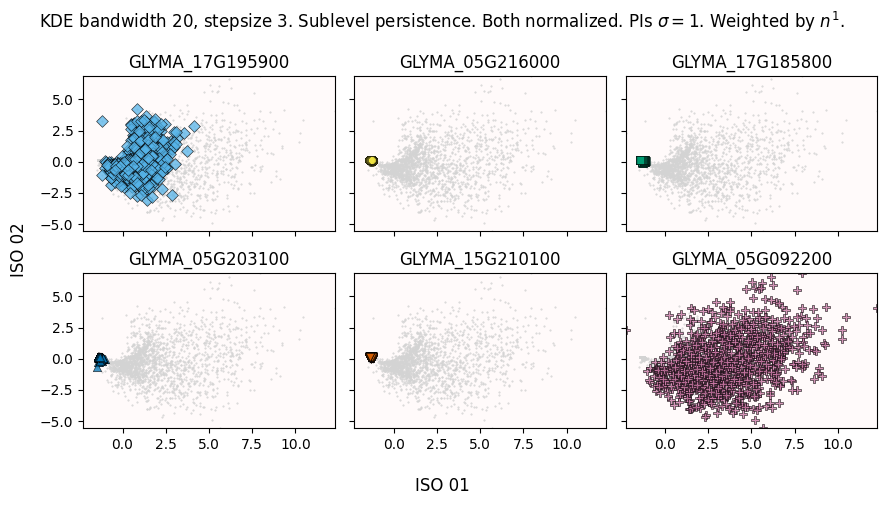

In [42]:
summary = pd.DataFrame(iso, columns=['{}{:02d}'.format(method, i+1) for i in range(iso.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(iso.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}.csv'.format(method.lower(), params['n_neighbors']))

fig, ax = plot_embedding(iso, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['n_neighbors'])
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# tSNE

In [43]:
method = 'tSNE'
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=25,
    init="random",
    n_iter=250,
    random_state=seed,
)
tsne = t_sne.fit_transform(fulldata).astype('float32')
params = t_sne.get_params()

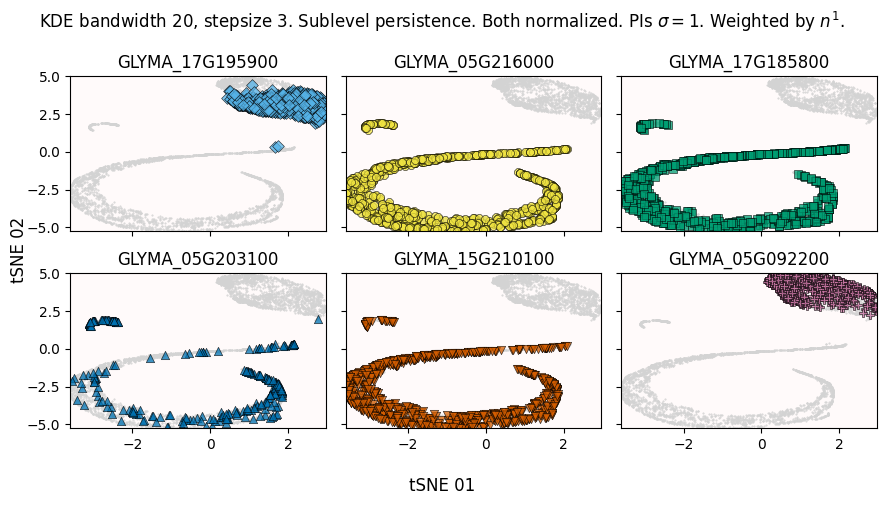

In [44]:
summary = pd.DataFrame(tsne, columns=['{}{:02d}'.format(method, i+1) for i in range(tsne.shape[1])])
summary['gene_ID'] = Genes[gmask]
summary['ndimage_ID'] = Cells[cmask]
summary.iloc[:, [-1,-2] + list(range(tsne.shape[1]) )]
#summary.to_csv(tdst + bname + '{}_{}.csv'.format(method.lower(), params['perplexity']))

fig, ax = plot_embedding(tsne, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}.csv'.format(method.lower(), params['perplexity'])
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# UMAP

In [39]:
method = 'UMAP'
ufit = umap.UMAP(n_neighbors=10, min_dist=0.25, n_components=2, metric='euclidean', random_state=seed, n_jobs=1)
u_umap = ufit.fit_transform(fulldata);
params = ufit.get_params();

/home/eah4d/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


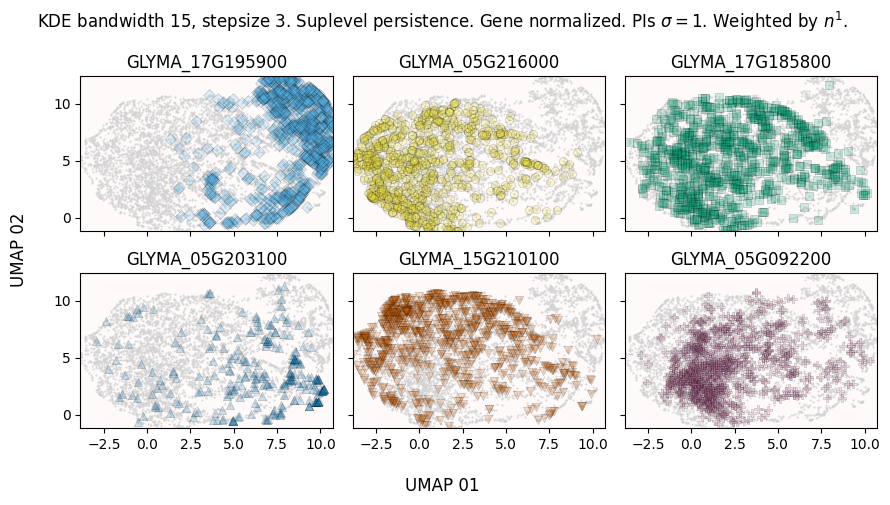

In [43]:
summary = pd.DataFrame(u_umap, columns=['{}{:02d}'.format(method, i+1) for i in range(u_umap.shape[1])])
summary['gene_ID'] = np.repeat(Genes, list(map(len, nzmask)) )
summary['ndimage_ID'] = np.hstack([ Cells[ nzmask[i] ] for i in range(len(nzmask)) ])
summary.iloc[:, [-1,-2] + list(range(u_umap.shape[1]) )]
summary.to_csv(tdst + bname + '{}_{}_{}_{}_{}.csv'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'],params['n_components']))

fig, ax = plot_embedding(u_umap, 0.0, method, nrows=nrows, ncols=ncols)
fig.suptitle(Bname)
fig.tight_layout();
filename = tdst + bname + '{}_{}_{}_{}_{}'.format(method.lower(), params['n_neighbors'], params['min_dist'],params['metric'],params['n_components'])
plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# Match to Wasserstein distance

In [60]:
import itertools
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 
isrc += sample + os.sep

ws_o = 1
internal_p = np.inf
if internal_p == np.inf:
    ws_p = '\\infty'
else:
    ws_p = str(internal_p)

it = list(itertools.combinations(range(len(Genes)), 2))
columns = np.asarray([ '{}_-_vs_-_{}'.format(transcriptomes[Genes[foo[0]]],transcriptomes[Genes[foo[1]]]) for foo in it])
filename = isrc + 'wasserstein{}d_{}_-_{}level_-_by_{}'.format(ws_o, ws_p.replace('\\',''), level, normtype)

ws1 = pd.read_csv(filename + '.csv', index_col=0)
with open(filename + '.json') as f:
    dmatch = json.load(f)
print('Compared', len(dmatch), 'pairs of diagrams')
ws1.head()

Compared 10614 pairs of diagrams


,GLYMA_17G195900_-_vs_-_GLYMA_05G216000,GLYMA_17G195900_-_vs_-_GLYMA_17G185800,GLYMA_17G195900_-_vs_-_GLYMA_05G203100,GLYMA_17G195900_-_vs_-_GLYMA_15G210100,GLYMA_17G195900_-_vs_-_GLYMA_05G092200,GLYMA_05G216000_-_vs_-_GLYMA_17G185800,GLYMA_05G216000_-_vs_-_GLYMA_05G203100,GLYMA_05G216000_-_vs_-_GLYMA_15G210100,GLYMA_05G216000_-_vs_-_GLYMA_05G092200,GLYMA_17G185800_-_vs_-_GLYMA_05G203100,GLYMA_17G185800_-_vs_-_GLYMA_15G210100,GLYMA_17G185800_-_vs_-_GLYMA_05G092200,GLYMA_05G203100_-_vs_-_GLYMA_15G210100,GLYMA_05G203100_-_vs_-_GLYMA_05G092200,GLYMA_15G210100_-_vs_-_GLYMA_05G092200
ndimage_ID,,,,,,,,,,,,,,,
742,118.959835,NaN,NaN,133.539224,327.996576,NaN,NaN,28.259547,223.314988,NaN,NaN,NaN,NaN,NaN,230.633373
842,310.153086,292.168918,NaN,317.498865,444.566202,56.462265,NaN,20.894739,271.381668,NaN,60.926221,252.530425,NaN,NaN,279.565037
2052,297.745725,289.535611,NaN,292.478642,533.569414,34.595498,NaN,18.470045,317.790741,NaN,19.881242,311.551000,NaN,NaN,312.523658
1145,240.893439,200.288864,180.552672,203.936608,184.418852,48.387111,64.030185,54.227541,253.380191,21.471638,37.478485,212.775616,29.454654,193.039424,216.423360
896,260.494339,267.688913,NaN,253.817726,196.561986,91.130656,NaN,32.228374,243.670121,NaN,81.592263,250.864695,NaN,NaN,236.993509


In [140]:
gi, gj = 0,1
foo = '{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])
print(foo)
diff = ws1[foo]

alpha = 0.025

vmin,vmax = np.quantile(diff.values, [alpha,1-alpha])
q1, q3 = np.quantile(diff.values, [0.25, 0.75])
iqr = q3 - q1

vmin = max([diff.min(), q1-iqr])
vmax = min([diff.max(), q3+iqr])

GLYMA_17G195900_-_vs_-_GLYMA_05G092200


In [185]:
embedding = u_umap.copy()

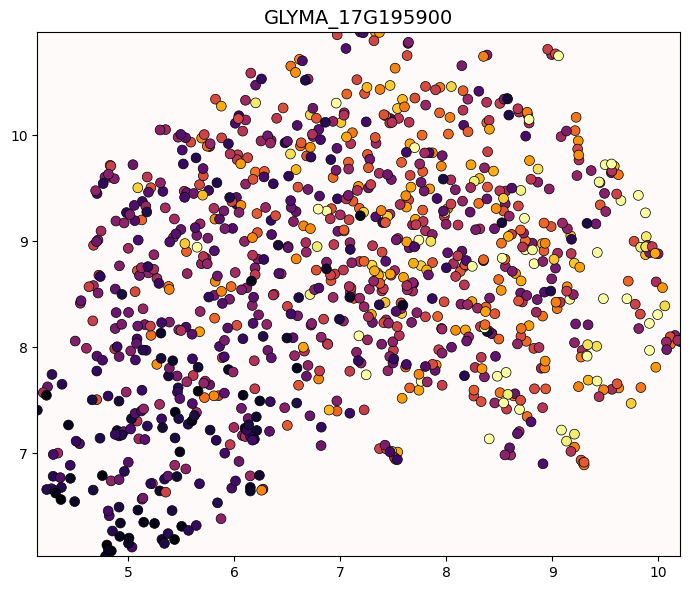

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(7,7), sharex=True, sharey=True); ticks = False
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(embedding[:,0], embedding[:,1], c=diff.values, marker='o', cmap = 'inferno',
              edgecolor='k', linewidth=0.5, alpha=1, zorder=2, s=50, vmin=vmin, vmax=vmax)
ax[i].set_facecolor('snow')
ax[i].set_title(transcriptomes[Genes[jx]], fontsize=fs)
#ax[i].tick_params(left=ticks, labelleft=ticks, labelbottom=ticks, bottom=ticks);
ax[i].margins(0)
ax[i].set_aspect('equal')

fig.tight_layout();

In [194]:
N = 25
bins = np.linspace(embedding[:,0].min(), embedding[:,0].max(), N)
bins[-1] += 1
digitize = np.digitize(embedding[:,0], bins)
aux = np.zeros((len(bins)-1, 4))

for i in range(len(aux)):
    foo = diff.values[digitize == i+1]
    bar = [i, bins[i], np.min(foo), np.median(foo), np.mean(foo), np.max(foo)]
    aux[i] = bar[2:]
    print('{:02d}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(*bar) )

00	4.15	35.36	134.02	160.81
01	4.40	70.22	202.50	215.93
02	4.65	38.44	229.99	240.24
03	4.90	54.55	214.48	235.30
04	5.15	59.09	233.26	265.11
05	5.41	31.33	213.56	240.34
06	5.66	41.01	318.75	338.27
07	5.91	62.67	288.27	278.01
08	6.16	72.07	288.31	299.48
09	6.42	66.91	313.08	347.84
10	6.67	87.10	338.27	391.06
11	6.92	91.23	376.31	382.15
12	7.17	73.06	434.77	441.95
13	7.43	82.64	388.58	411.12
14	7.68	156.39	418.11	435.46
15	7.93	114.81	396.45	396.16
16	8.18	106.57	404.12	435.98
17	8.44	96.87	416.20	464.71
18	8.69	187.72	484.06	486.00
19	8.94	123.23	394.30	455.62
20	9.19	116.17	543.46	538.69
21	9.45	293.31	481.81	529.65
22	9.70	268.70	655.59	644.41
23	9.95	225.05	406.12	458.75


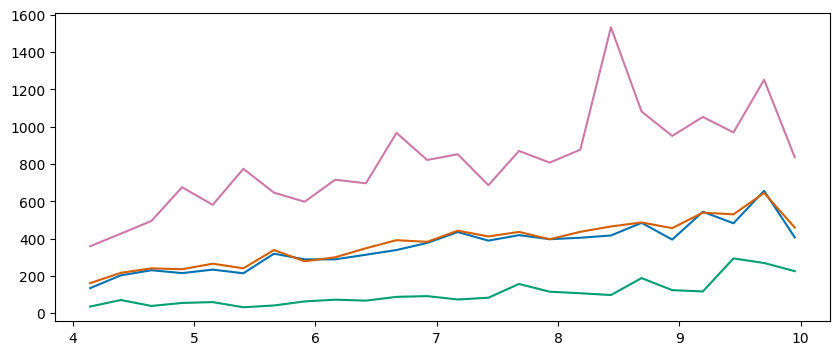

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=True, sharey=True); ticks = False
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(aux.shape[1]):
    ax[i].plot(bins[:-1], aux[:,j], color=color[j+2])